## Time to get your hands dirty! Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


---



# Gamma Ray Bursts

## Data Loading

In [1]:
import numpy as np
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data_values = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')
print(data_values.shape)

# Read headers
with open("Summary_table.txt",'r') as f:
    data_names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

data = dict(zip(data_names, data_values))

print(data_names)

(15, 8879)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In the following lines we study two value: 
- $T_{90}$ and his error: duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%.
- $fluence$ and his error: The time integrated total energy per unit surface.

In [2]:
T90, T90_err = np.array(data['T90'], dtype=float), np.array(data['T90_error'], dtype=float)
fluence, fluence_err = np.array(data['fluence'], dtype=float), np.array(data['fluence_error'], dtype=float)

# Remove -999 values
for i in range(len(T90)):
    if T90_err[i] == -999:
        T90[i] = -999
    if fluence_err[i] == -999:
        fluence[i] = -999

T90 = T90[T90 != -999]
T90_err = T90_err[T90_err != -999]
fluence = fluence[fluence != -999]
fluence_err = fluence_err[fluence_err != -999]
print(f"T90: {T90.shape}, T90_err: {T90_err.shape}, fluence: {fluence.shape}, fluence_err: {fluence_err.shape}")

T90: (6662,), T90_err: (6662,), fluence: (6748,), fluence_err: (6748,)


## $T_{90}$

We can start analysing the distribution of the $\log_{10}(T_{90})$ and of $\log_{10}(\sigma_{T_{90}})$ visualizing the hstograms of these distributions. 


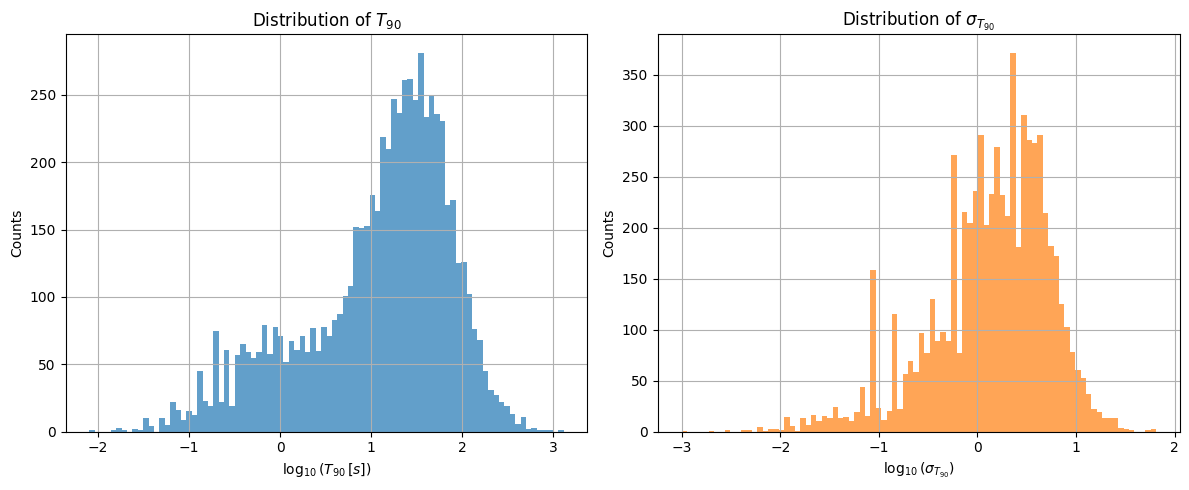

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for T90
axes[0].hist(np.log10(T90), bins=max(10, int(len(T90)/75)), alpha=0.7, color='tab:blue')
axes[0].set_xlabel(r'$\log_{10}(T_{90} \, [s])$')
axes[0].set_ylabel('Counts')
axes[0].grid(True)
axes[0].set_title('Distribution of $T_{90}$')

# Histogram for T90_err
axes[1].hist(np.log10(T90_err), bins=max(10, int(len(T90_err)/75)), alpha=0.7, color='tab:orange')
axes[1].set_xlabel(r'$\log_{10}(\sigma_{T_{90}})$')
axes[1].set_ylabel('Counts')
axes[1].grid(True)
axes[1].set_title(r'Distribution of $\sigma_{T_{90}}$')

plt.tight_layout()
plt.show()

As we have seen some lecture ago, the histogram is not the only way to visualize the data, an other way is to use the KDE. 
But how can I choose the best `kernel` and the best `bandwith` to use?

### Cross-validation
The cross-validation is a tecnique to **tune the hyperparameters** of a model. 
The basic idea is to divide the training set in some folds, `cv`, and use one of this fold as the validation set. This operation is computed many times changing the fold that is used as validation set in order to try all the possible combinations. In this way each point of the set is used both for training and validation at least one time. 

Once the algorithm complete all the operations the best set of hyperparaemters are returned.

In [4]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def cross_validation_kde(train_set, bandwidths, kernels, cv=5):
    grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': bandwidths,
                         'kernel': kernels},
                        cv=cv)  # 5-fold cross-validation
    grid.fit(train_set[:, np.newaxis])
    print("Best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
    print("Best kernel: {0}".format(grid.best_estimator_.kernel))
    return grid.best_estimator_.bandwidth, grid.best_estimator_.kernel

kernels = ['gaussian', 'tophat', 'epanechnikov']
bandwidths = np.linspace(0.01,1.0, 40)

best_bandwidth, best_kernel = cross_validation_kde(np.log10(T90), bandwidths, kernels, cv=5)


Best bandwidth: 0.11153846153846153
Best kernel: gaussian


/mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-1547.69561338           -inf           -inf -1480.93841301
           -inf           -inf -1478.91153824           -inf
           -inf -1477.86600772           -inf           -inf
 -1477.47937713           -inf           -inf -1477.69931596
           -inf           -inf -1478.55639848           -inf
           -inf -1480.13159476           -inf           -inf
 -1482.50158901           -inf           -inf -1485.72761254
           -inf           -inf -1489.84865188           -inf
           -inf -1494.87816035 -1483.31173001 -1477.9898952
 -1500.80486004 -1477.84364906 -1477.98548592 -1507.59603871
 -1479.81601833 -1477.99734852 -1515.20202508 -1483.29247275
 -1478.4172384  -1523.56101281 -1485.0766593  -1479.09434214
 -1532.60370173 -1485.80263078 -1479.87022715 -1542.25743228
 -1489.4852043  -1480.90181974 -1552.4496

Once we have choose the best set of parameter we can draw the KDE.

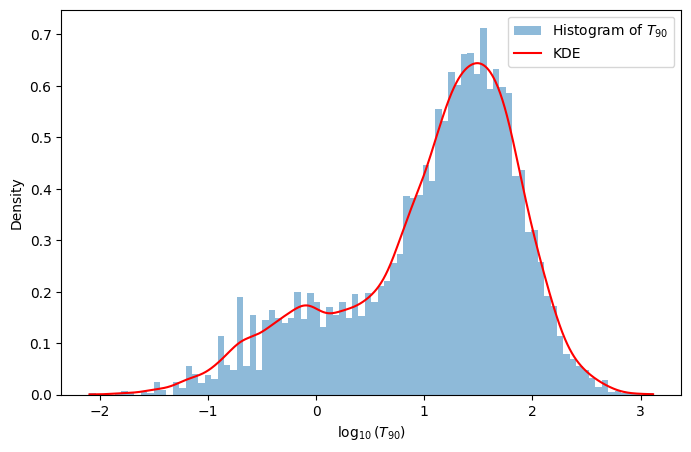

In [5]:
def kd_function(train_set, test_set, bandwidth, kernel):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(train_set[:, np.newaxis])
    log_density = kde.score_samples(test_set[:, np.newaxis])
    return np.exp(log_density)

pdf = kd_function(np.log10(T90), np.linspace(min(np.log10(T90)), max(np.log10(T90)), 1000), bandwidth=best_bandwidth, kernel=best_kernel)
x_values = np.linspace(min(np.log10(T90)), max(np.log10(T90)), 1000)

plt.figure(figsize=(8, 5))
plt.hist(np.log10(T90), bins=max(10, int(len(T90)/75)), density=True, alpha=0.5, label='Histogram of $T_{90}$')
plt.plot(x_values, pdf, label='KDE', color='red')
plt.xlabel('$\log_{10}(T_{90})$')
plt.ylabel('Density')
plt.legend()
plt.show()

### Clustering algorithm

In the image above we can see how the KDE seams to be made of, at least, 2 principal gaussian pdf, for these reason we set `n_clusters=2`. 
To do this we use three different algorithm: 
- `KMeans`: Assign each point to the nearest centroid, compute the mean of points in each cluster, update centroids, and repeat until the within-cluster **squared distance is minimized**. Run the process multiple times with different initial centroids and keep the best solution.
- `GaussianMixture`: Based on the idea of fit the data with a **sum of gaussian distributions**. This algorithm is described in the Ex.5.
- `MeanShift`: A KDE is built from the data, gradients are computed, and each point is iteratively moved toward **higher density regions**. Points converge to local maxima (modes) of the distribution, forming clusters where nearby points group together.

In this part we study only the sistribution of $T_{90}$.

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(np.log10(T90)[:, np.newaxis])
kmean_centers = kmeans.cluster_centers_

In [7]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(np.log10(T90)[:, np.newaxis])
labels_gmm = gmm.predict(np.log10(T90)[:, np.newaxis])
gmm_centers = gmm.means_.flatten()

In [8]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift(bandwidth=0.4)
mean_labels = mean_shift.fit_predict(np.log10(T90)[:, np.newaxis])
meanshift_centers = mean_shift.cluster_centers_

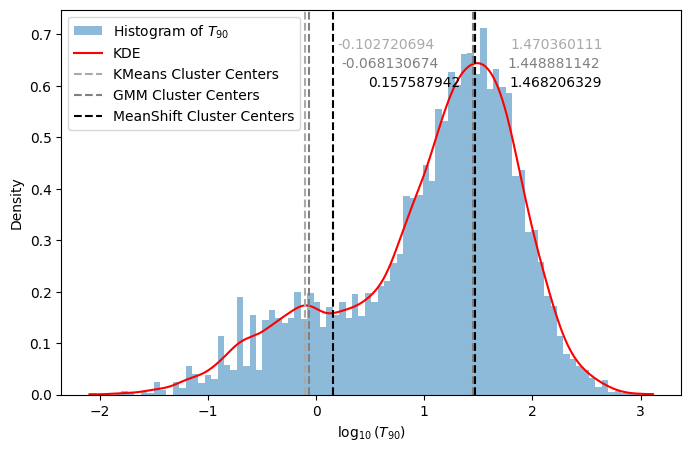

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(np.log10(T90), bins=max(10, int(len(T90)/75)), density=True, alpha=0.5, label='Histogram of $T_{90}$')
plt.plot(x_values, pdf, label='KDE', color='red')
for i, center in enumerate(kmean_centers):
    plt.axvline(center, color="darkgray", linestyle='--', label=f'KMeans Cluster Centers' if i == 0 else "")
    plt.text(center + 0.75, plt.ylim()[1]*0.9, str(round(center[0], 9)), horizontalalignment='center', color='darkgray')
for i, center in enumerate(gmm_centers):
    plt.axvline(center, color="gray", linestyle='--', label=f'GMM Cluster Centers' if i == 0 else "")
    plt.text(center + 0.75, plt.ylim()[1]*0.85, str(round(center, 9)), horizontalalignment='center', color='gray')
for i, center in enumerate(meanshift_centers):
    plt.axvline(center, color="k", linestyle='--', label=f'MeanShift Cluster Centers' if i == 0 else "")
    plt.text(center + 0.75, plt.ylim()[1]*0.8, str(round(center[0], 9)), horizontalalignment='center', color='k')
plt.xlabel('$\log_{10}(T_{90})$')
plt.ylabel('Density')
plt.legend()
plt.show()

We can see how changing the algorithm the position of the centers doesn't change too much

In [10]:
print("KMeans Cluster Edges:\n", np.mean(kmean_centers, axis=0))
print("GMM Cluster Edges:\n", np.mean(gmm_centers, axis=0))
print("MeanShift Cluster Edges:\n", np.mean(meanshift_centers, axis=0))

KMeans Cluster Edges:
 [0.68381971]
GMM Cluster Edges:
 0.690375233872937
MeanShift Cluster Edges:
 [0.81289714]


We can now analyze also the errors, so we can use a 2D plot of $\log_{10}(T_{90})$ vs $\log_{10}(\sigma_{T_{90}})$

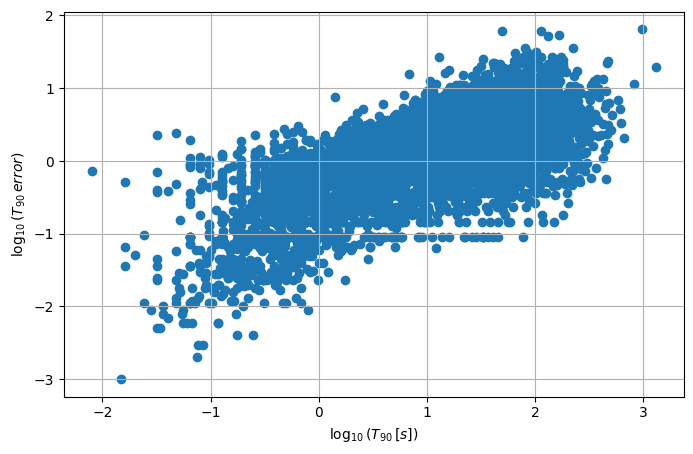

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(np.log10(T90), np.log10(T90_err))
plt.xlabel(r'$\log_{10}(T_{90} \, [s])$')
plt.ylabel(r'$\log_{10}(T_{90} \, error)$')
plt.grid(True)
plt.show()

KMeans 2D Cluster Centers:
 [[ 1.46394175  0.37011344]
 [-0.08762471 -0.58177449]]


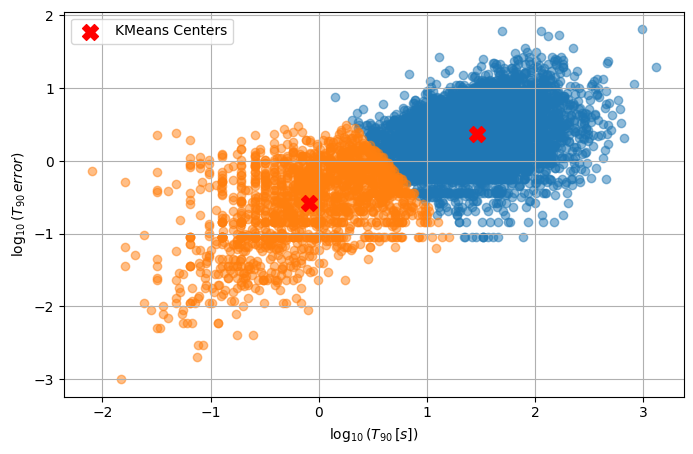

In [12]:
n_clusters = 2
kmean2D = KMeans(n_clusters=n_clusters)
kmean2D.fit(np.column_stack((np.log10(T90), np.log10(T90_err))))
kmean2D_centers = kmean2D.cluster_centers_
print("KMeans 2D Cluster Centers:\n", kmean2D_centers)

X = np.column_stack((np.log10(T90), np.log10(T90_err)))
kmean_labels = kmean2D.predict(X)

plt.figure(figsize=(8, 5))
for i in range(n_clusters):
    plt.scatter(X[kmean_labels==i,0], X[kmean_labels==i,1], alpha=0.5)
for i, center in enumerate(kmean2D_centers):
    plt.scatter(center[0], center[1], color='red', marker='X', s=130, label='KMeans Centers' if i == 0 else "")
plt.xlabel(r'$\log_{10}(T_{90} \, [s])$')
plt.ylabel(r'$\log_{10}(T_{90} \, error)$')
plt.grid(True)
plt.legend()
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
number of estimated clusters : 23


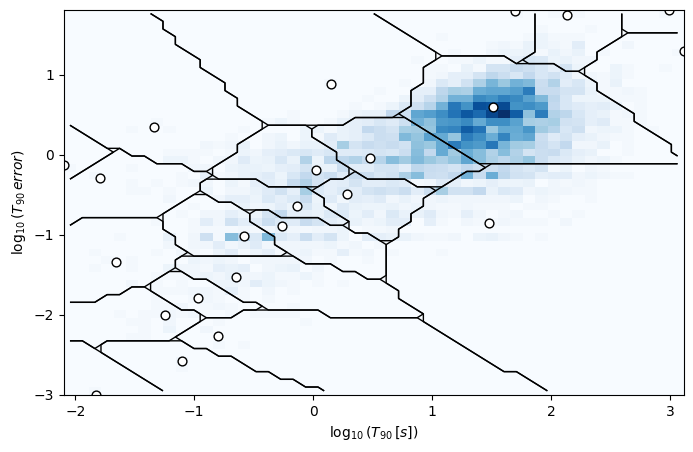

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mean_shift2D = MeanShift(bandwidth=0.4)
mean_shift2D.fit(scaler.fit_transform(X))

labels_unique = np.unique(mean_shift2D.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()

H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(mean_shift2D.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = mean_shift2D.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = mean_shift2D.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r'$\log_{10}(T_{90} \, [s])$')
ax.set_ylabel(r'$\log_{10}(T_{90} \, error)$')

plt.show()

We can see how in the last case the algorithm find lot of other centers compared to the 1D case. 
These reslut tell us a lot about the sensibility of these algorithm to outliers points. 
- `KMeans` is sensitive to outliers as it minimizes squared distances.
- `MeanShift` is less sensitive as it focuses on density peaks, and the outliers are treated as new centers.

## $fluence$

KMeans Cluster Centers:
 [[-6.56996435]
 [-5.25390971]]
KMeans 2D Cluster Centers:
 [[-6.63000834 -7.71517543]
 [-5.2994427  -7.14439636]]


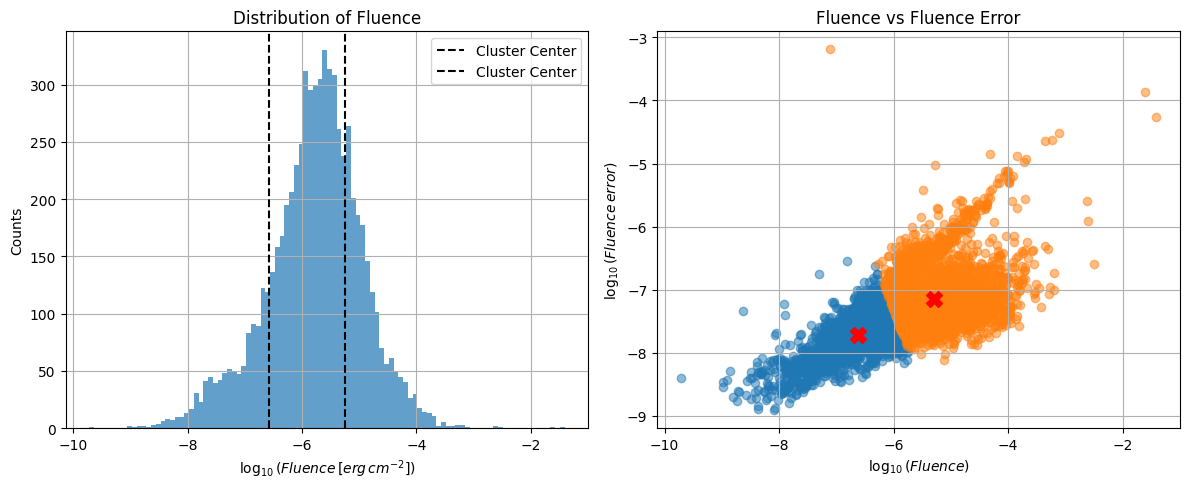

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KMeans clustering for fluence
kmean = KMeans(n_clusters=2, random_state=42)
kmean.fit(np.log10(fluence[fluence > 0])[:, np.newaxis])
kmean_centers = kmean.cluster_centers_
print("KMeans Cluster Centers:\n", kmean_centers)

# Histogram for fluence
axes[0].hist(np.log10(fluence[fluence > 0]), bins=100, alpha=0.7, color='tab:blue')
for center in kmean_centers:
    axes[0].axvline(center[0], color='k', linestyle='--', label='Cluster Center')
axes[0].set_xlabel(r'$\log_{10}(Fluence \, [erg \, cm^{-2}])$')
axes[0].set_ylabel('Counts')
axes[0].grid(True)
axes[0].set_title('Distribution of Fluence')
axes[0].legend()

# KMeans clustering for fluence vs fluence_err
n_clusters = 2
valid_indices = (fluence > 0)
kmean2D = KMeans(n_clusters=n_clusters)
kmean2D.fit(np.column_stack((np.log10(fluence[valid_indices]), np.log10(fluence_err[valid_indices]))))
kmean2D_centers = kmean2D.cluster_centers_
print("KMeans 2D Cluster Centers:\n", kmean2D_centers)
kmean_labels = kmean2D.predict(np.column_stack((np.log10(fluence[valid_indices]), np.log10(fluence_err[valid_indices]))))

# Scatter plot for fluence vs fluence_err
for i in range(n_clusters):
    axes[1].scatter(np.log10(fluence[valid_indices])[kmean_labels==i], np.log10(fluence_err[valid_indices])[kmean_labels==i], alpha=0.5)
for center in kmean2D_centers:
    axes[1].scatter(center[0], center[1], color='red', marker='X', s=130)
axes[1].set_xlabel(r'$\log_{10}(Fluence)$')
axes[1].set_ylabel(r'$\log_{10}(Fluence \, error)$')
axes[1].grid(True)
axes[1].set_title('Fluence vs Fluence Error')

plt.tight_layout()
plt.show()

We can see how the $fluence$ is less sensible to multi-modality.